In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
df = pd.read_csv('AB_NYC_2019.csv')

1. I noticed that some host names and listing names were empty, so I removed those entries. I also noticed that a lot of room prices seemed unrealistic, so I removed all entries with outliers in the price column using 1.5 * IQR above or below the first and third quartiles to define an outlier. However, this cut out what I thought to be too many high values and left in entries with a price of 0, which was clearly bad data. So I decided to take the logarithm of the price values before using using 1.5 * IQR to remove outliers. This seemed to work much better and succesfully removed the unrealistic prices at the low and high ends of the spectrum after I manually removed prices of 0 to avoid takign the logarithm of 0. I also removed all the listings that were open for 0 days a year, as well as any listings where the minimum amount of nights was greater than the number of days a year the listing is available for booking, since those listings can't be booked.

In [63]:
df = df[df['name'].notna()] #remove null names
df = df[df['host_name'].notna()] #remove null host names
df = df[df['price'] > 0] #remove listings with price less than or equal to 0
df['log_price'] = np.log10(df['price']) #create log price column
logPriceIQR = df['log_price'].quantile(0.75) - df['log_price'].quantile(0.25) #calculate IQR
lowerBound = df['log_price'].quantile(0.25) - 1.5 * logPriceIQR #calculate lower bound
upperBound = df['log_price'].quantile(0.75) + 1.5 * logPriceIQR #calculate upper bound
df = df[df['log_price'] >= lowerBound] #remove lower price outliers
df = df[df['log_price'] <= upperBound] #remove upper price outliers
df = df[df['availability_365'] > 0] #remove listings with 0 availability
df = df[df['minimum_nights'] <= df['availability_365']] #remove listings with minimum nights greater than availability

2. 
    a.

In [64]:
dfNh = df.pivot(index = 'neighbourhood', columns = 'id', values = 'price') #pivot on neighborhood (why does this dataset use british english???)
dfNh['num_listings'] = dfNh.count(axis = 1) #count listings
dfNh = dfNh[dfNh['num_listings'] > 5] #only more than 5 listing
dfNh['mean_price'] = dfNh.mean(axis = 1) #calculate mean price
dfNh = dfNh.sort_values('mean_price') #sort ascending price
print('top 5 expensive neighborhoods')
print(dfNh[['mean_price']].tail(5))
print('top 5 cheapest neighborhoods')
print(dfNh[['mean_price']].head(5))

top 5 expensive neighborhoods
id                 mean_price
neighbourhood                
West Village       239.415789
Midtown            255.345691
NoHo               304.764706
Tribeca            305.166667
Flatiron District  306.439024
top 5 cheapest neighborhoods
id             mean_price
neighbourhood            
Hunts Point     42.941176
Tremont         49.500000
Grant City      50.285714
Soundview       51.461538
Bronxdale       51.928571


2.
    b.

Text(0.5, 1.0, 'Mean Price by Neighborhood Group')

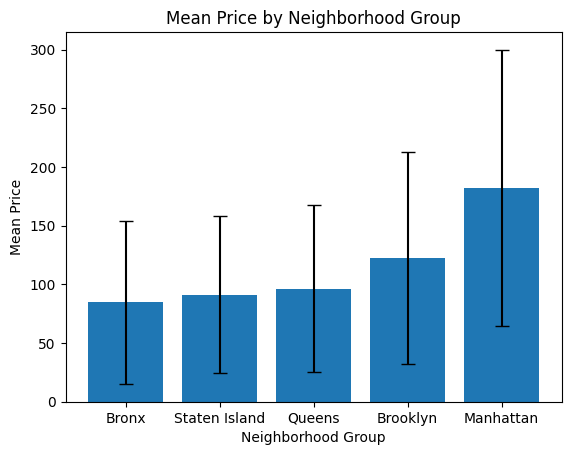

In [65]:
dfNhG = df.pivot(index = 'neighbourhood_group', columns = 'id', values = 'price') #pivot on neighborhood group
dfNhG['mean_price'] = dfNhG.mean(axis = 1) #calculate mean price
dfNhG['stdev_price'] = dfNhG.std(axis = 1) #calculate standard deviation
dfNhG = dfNhG.sort_values('mean_price') #sort ascending price
plt.bar(dfNhG.index, dfNhG['mean_price'], yerr = dfNhG['stdev_price'], capsize = 5) #plot bar graph
plt.xlabel('Neighborhood Group')
plt.ylabel('Mean Price')
plt.title('Mean Price by Neighborhood Group')

3. I chose the following set of most interesting features:
    - reviews_per_month
    - availability_365
    - minimum_nights
    - number_of_reviews
    - price

    the most positive correlation was reviews_per_month and number_of_reviews, while the most negative was reviews_per_month and minimum_nights (although at a correlation of about -0.2, they aren't very correlated). 

Text(0.5, 1.0, 'Correlation Heatmap')

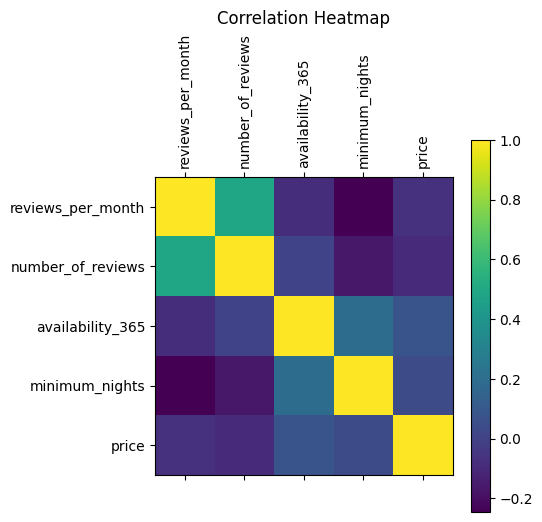

In [66]:
dfPairwise = df[['reviews_per_month', 'number_of_reviews', 'availability_365', 'minimum_nights', 'price']] #select columns
dfPairwise = dfPairwise.corr() #calculate correlation
plt.matshow(dfPairwise) #plot heatmap
plt.xticks(range(len(dfPairwise.columns)), dfPairwise.columns, rotation = 90) #label x axis sideways
plt.yticks(range(len(dfPairwise.columns)), dfPairwise.columns) #label y axis
plt.colorbar() #add colorbar
plt.title('Correlation Heatmap')

4. a.

C:\Users\antee\AppData\Local\Temp\ipykernel_9672\3359323345.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(df['neighbourhood_group'].astype('category').unique().categories, label = 'Borough') #label colorbar with boroughs instead of numbers


Text(0.5, 1.0, 'NYC Airbnb Listings Colored by Borough')

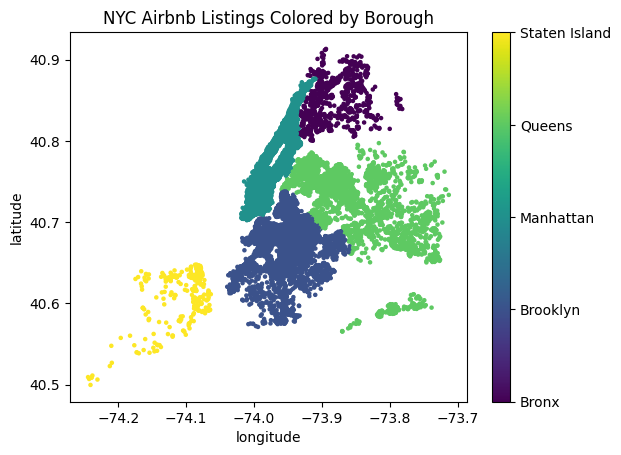

In [67]:
plt.scatter(df['longitude'], df['latitude'], c = df['neighbourhood_group'].astype('category').cat.codes, s = 5) #scatter plot using neighborhood group as color
cbar = plt.colorbar()
cbar.ax.set_yticklabels(df['neighbourhood_group'].astype('category').unique().categories, label = 'Borough') #label colorbar with boroughs instead of numbers
cbar.ax.locator_params(nbins = 5) #limit number of colorbar labels so that the borough labels are accurate
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('NYC Airbnb Listings Colored by Borough')

4. b. Manhattan clearly has the most colorful dots in the scatter plot, which means that it has the most expensive listings.

Text(0.5, 1.0, 'NYC Airbnb Listings Colored by Price')

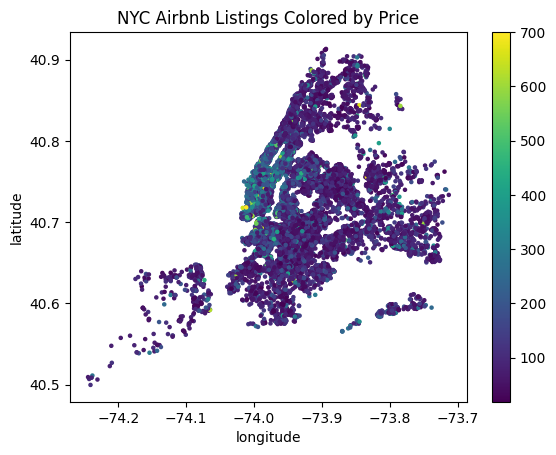

In [68]:
dfLL = df[df['price'] < 1000]
plt.scatter(dfLL['longitude'], dfLL['latitude'], c = dfLL['price'], s = 5) #scatter plot using price as color
plt.colorbar() #add colorbar
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('NYC Airbnb Listings Colored by Price')

5. 

Text(0.5, 1.0, 'Word Cloud of Airbnb Names')

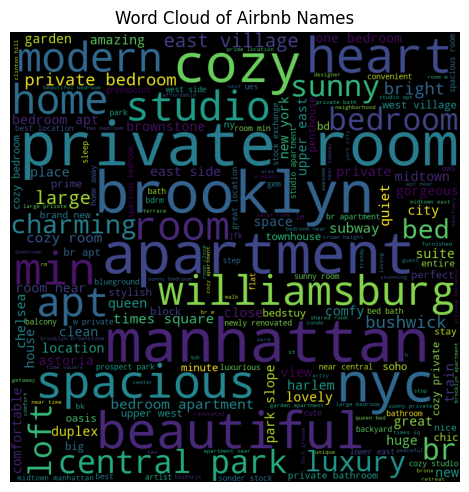

In [70]:
regex = re.compile('[^a-z \']') #regex to remove characters that are not letters, spaces, or apostrophes
wordList = '' #empty word list
for str in df['name']:
    if str is not None:
        str = str.lower() #convert to lowercase
        str = regex.sub('', str) #remove unwanted characters
        wordList += str + ' ' #add to word list
wordcloud = WordCloud(width = 800, height = 800, stopwords = STOPWORDS).generate(wordList) #create word cloud
plt.imshow(wordcloud) #plot word cloud
plt.axis('off') #turn off axes
plt.tight_layout() #prevents clipping but also makes more words appear horizontal for some reason which improves readbility
plt.title('Word Cloud of Airbnb Names')

7. 

       calculated_host_listings_count    host_id          host_name
41417                             327  219517861       Sonder (NYC)
38718                             232  107434423         Blueground
11886                             121   30283594               Kara
40405                             103  137358866             Kazuya
32199                              96   12243051             Sonder
12080                              96   16098958     Jeremy & Laura
26668                              91   61391963  Corporate Housing
16210                              87   22541573                Ken
34386                              65  200380610            Pranjal
3533                               52    7503643               Vida
37606                              52    1475015               Mike
26681                              50  120762452            Stanley
34332                              49  205031545         Red Awning
16265                              49    2856748

Text(0.5, 1.0, 'Correlation Heatmap')

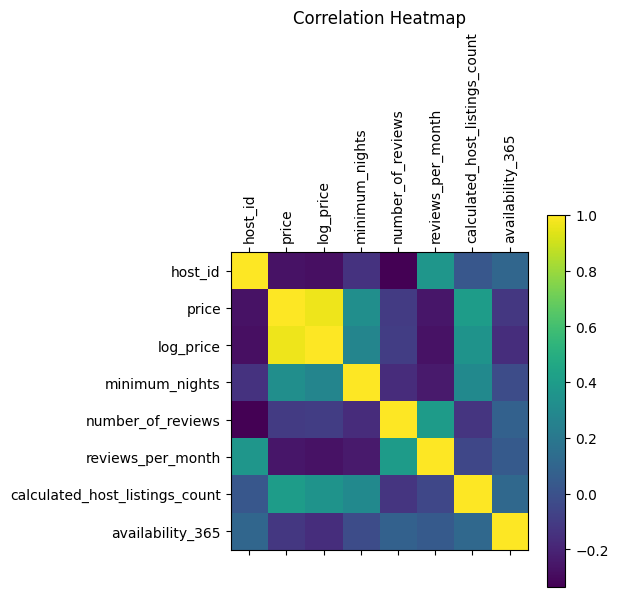

In [99]:
dfListings = df.sort_values('calculated_host_listings_count', ascending = False) #sort by host listing count
dfListings = dfListings[['calculated_host_listings_count', 'host_id', 'host_name']] #select columns
dfListings = dfListings.drop_duplicates()
print(dfListings.head(20)) #print top 20 hosts
dfNhAvg = df[['neighbourhood', 'host_id', 'price', 'log_price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] #select columns
dfNhAvg = dfNhAvg.groupby('neighbourhood').mean() #group by neighborhood and calculate mean
dfNhAvg = dfNhAvg.sort_values('calculated_host_listings_count', ascending = False) #sort by host listings
print(dfNhAvg.head(20)) #print top 20 neighborhoods
dfNhAvg = dfNhAvg.corr() #calculate correlation
plt.matshow(dfNhAvg) #plot heatmap
plt.xticks(range(len(dfNhAvg.columns)), dfNhAvg.columns, rotation = 90) #label x axis sideways
plt.yticks(range(len(dfNhAvg.columns)), dfNhAvg.columns) #label y axis
plt.colorbar() #add colorbar
plt.title('Correlation Heatmap')